# Академия Аналитиков Авито

# Эконометрика

Общий план курса:
- Повторение теории вероятности и математической статистики
- Классическая линейная регрессия
- Множественная регрессия
- Метрики качества регрессии и проверка гипотез, связанных с ней
- Нарушение предпосылок теоремы Гаусса-Маркова
- Модели бинарного выбора
- **Временные ряды**

# Занятие №9 

- На предыдущем занятии мы

- Научились тестировать на наличие автокорреляции

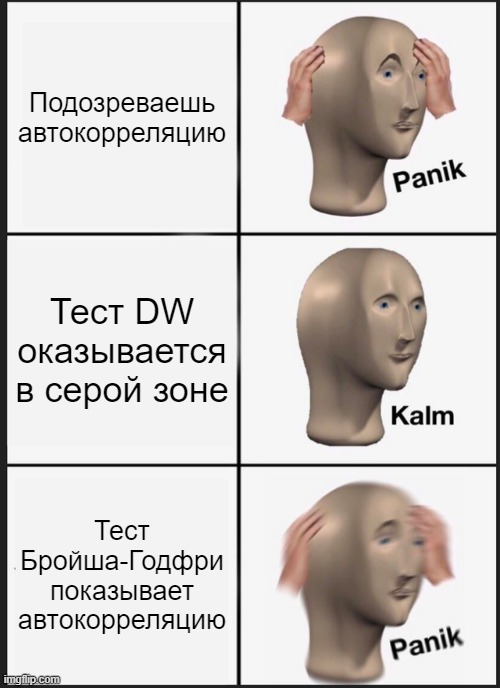

- Немного затронули `ARMA` модели

![image.png](https://i.imgflip.com/28qotz.jpg)

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy as sp
import seaborn as sns

# Модельки
from statsmodels.tsa.arima.model import ARIMA
# Тесты
from statsmodels.tsa.stattools import adfuller, kpss, acf

import prophet as fp 
import datetime
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot


import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# инициализируем plotly
init_notebook_mode(connected = True)

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

In [2]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput, '\n Null Hypothesis: The series has a unit root.')
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output, '\n Null Hypothesis: The process is trend stationary.')

# FBProphet

[**Документация**](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

[**Пример данных взят с задачи на kaggle**](https://www.kaggle.com/c/m5-forecasting-uncertainty/data)

**Технические функции**

In [116]:
# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
# Функция для получения данных 'mdape', 'mape', 'mtape' для модели по методу имитированных исторических прогнозов
def perf_metrics_28d(fp_model):
    fp_df_cv = cross_validation(fp_model, initial='730.25 days', period='28 days', horizon = '28 days', parallel="processes")
    res = performance_metrics(fp_df_cv,rolling_window = 1)
    return res

#### План занятия: 
- Получение данных
- Знакомство с библиотекой fbprophet - базовая модель
  1. Формат подаваемых данных 
  2. Базовая модель и параметры по умолчанию
  3. Декомпозиция временного ряда на составляющие
- Ошибка прогноза и кросс-валидация
- Основные параметры, влияющие на модель
  1. Точки изменения тренда
  2. Сезонные компоненты
  3. Эффекты праздников
- Добавление нового предиктора

**Получение данных**

Для нашего примера возьмем данные о продажах Walmart, крупнейшей в мире компании по выручке, для прогнозирования ежедневных продаж на следующие 28 дней. С кейсом можно озанкомиться на kaggle: [M5 Forecasting - Uncertainty](https://www.kaggle.com/c/m5-forecasting-uncertainty/overview)

Данные охватывают магазины в трех штатах США (Калифорния, Техас и Висконсин) и включают в себя детализацию о товаре - отдел, категорию и информацию о точке продаж. Кроме того, есть поясняющие переменные, такие как день недели и особые события. Вместе этот набор данных можно использовать для повышения точности прогнозов.

Для нас это замечательный пример реальной потребности бизнеса в прогнозах продаж. Для себя мы ее немного упростим и займемся только **предсказанием количества проданных товаров в одном штате в одной категории в целом** (не углубляясь до торговых точек)

In [57]:
# Получение и обработка исходных данных.

# Тренировочный датафрейм с проданными айтемами
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')

# Будем работать не с каждой конкретной точкой, а с продажами в каждом конкретном штате по категориям
stv_cols = [c for c in sales_train_evaluation.columns if c not in ['id','item_id','dept_id','store_id']]
sales_train_evaluation = sales_train_evaluation[stv_cols].groupby(['cat_id','state_id'], as_index = False).sum()

# Преобразуем данные в удобный формат
stv_cols_tr = [c for c in stv_cols if c not in ['cat_id','state_id']]
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars = ['cat_id','state_id'], \
                                value_vars = stv_cols_tr)

In [58]:
sales_train_evaluation

,cat_id,state_id,variable,value
0,FOODS,CA,d_1,10101
1,FOODS,TX,d_1,6853
2,FOODS,WI,d_1,6224
3,HOBBIES,CA,d_1,1802
4,HOBBIES,TX,d_1,879
...,...,...,...,...
17464,HOBBIES,TX,d_1941,1543
17465,HOBBIES,WI,d_1941,1223
17466,HOUSEHOLD,CA,d_1941,6160
17467,HOUSEHOLD,TX,d_1941,3772


In [59]:
# Cправочник дат. SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program)
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2', \
                     'snap_CA', 'snap_TX', 'snap_WI']]

In [60]:
calendar

,date,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [61]:
# Присоединение дат к id
sales_train_evaluation.columns = ['cat_id', 'state_id', 'd', 'y']
sales_train_evaluation = sales_train_evaluation.merge(calendar[['d', 'date']], how = 'left', on = 'd')

In [63]:
sales_train_evaluation

,cat_id,state_id,d,y,date
0,FOODS,CA,d_1,10101,2011-01-29
1,FOODS,TX,d_1,6853,2011-01-29
2,FOODS,WI,d_1,6224,2011-01-29
3,HOBBIES,CA,d_1,1802,2011-01-29
4,HOBBIES,TX,d_1,879,2011-01-29
...,...,...,...,...,...
17464,HOBBIES,TX,d_1941,1543,2016-05-22
17465,HOBBIES,WI,d_1941,1223,2016-05-22
17466,HOUSEHOLD,CA,d_1941,6160,2016-05-22
17467,HOUSEHOLD,TX,d_1941,3772,2016-05-22


In [65]:
# Приведение к нужному для fbtophet виду
sales_train_evaluation = sales_train_evaluation[['date', 'state_id', 'cat_id', 'y']]
sales_train_evaluation.columns = ['ds', 'state_id', 'cat_id', 'y']

In [66]:
# Данные без 4 последних недель - на них будем подбирать параметры нашей модели
sales_train_evaluation.tail()

,ds,state_id,cat_id,y
17464,2016-05-22,TX,HOBBIES,1543
17465,2016-05-22,WI,HOBBIES,1223
17466,2016-05-22,CA,HOUSEHOLD,6160
17467,2016-05-22,TX,HOUSEHOLD,3772
17468,2016-05-22,WI,HOUSEHOLD,3159


In [67]:
# Выделим только данные по Калифорнии
ca_data = sales_train_evaluation.loc[sales_train_evaluation.state_id == 'CA', ['ds', 'cat_id', 'y']].copy()

# Посмотрим на распрделение продаж по категориям
plotly_df(ca_data.pivot(index='ds', columns='cat_id', values='y'), title = 'CA items sold')

In [78]:
# Для нашего примера поработаем только с категорией 'FOODS'

data = ca_data.loc[(ca_data.cat_id == 'FOODS')&(ca_data.ds<=datetime.date(2016,4,24)),['ds', 'y']].copy().reset_index(drop = True)

data_evaluation = ca_data.loc[(ca_data.cat_id == 'FOODS'),['ds', 'y']].copy().reset_index(drop = True)

In [79]:
data

,ds,y
0,2011-01-29,10101
1,2011-01-30,9862
2,2011-01-31,6944
3,2011-02-01,7864
4,2011-02-02,7178
...,...,...
1908,2016-04-20,9863
1909,2016-04-21,9479
1910,2016-04-22,10991
1911,2016-04-23,13845


In [80]:
data_evaluation

,ds,y
0,2011-01-29,10101
1,2011-01-30,9862
2,2011-01-31,6944
3,2011-02-01,7864
4,2011-02-02,7178
...,...,...
1936,2016-05-18,10465
1937,2016-05-19,10650
1938,2016-05-20,11354
1939,2016-05-21,14489


## Знакомство с библиотекой fbprophet - базовая модель

<span style="color:blue">**1. Формат подаваемых данных**</span>

На вход принимается dataframe с двумя колонками:
- ds — время, поле должно быть типа date или datetime,
- y — числовой показатель, который мы хотим предсказывать.

Это условные обозначения, принятые в prophet. Использование каких–либо других имен приведет к ошибке при вызове соответствующих функций. Мы уже заранее подготовили нужный нам кусочек данных с правльным названием колонок. 

In [81]:
data.head()

,ds,y
0,2011-01-29,10101
1,2011-01-30,9862
2,2011-01-31,6944
3,2011-02-01,7864
4,2011-02-02,7178


In [82]:
plotly_df(data.set_index('ds'), title = 'CA items sold in Foods category')

<span style="color:blue">**2. Базовая модель и параметры по умолчанию**</span>

Модель прогнозирования Prophet - это модель прогнозирования временных рядов, предназначенная для работы с общими для бизнеса *особенностями* временных рядов (множественные сезонности, изменения тренда, праздники). 

<img src= "https://facebookexperimental.github.io/Robyn/img/prophet_decomp.png" width="50%" >


Подробное описание реализованной в Prophet методологии можно найти в соответствующей оригинальной статье [Taylor & Letham 2017](https://peerj.com/preprints/3190.pdf). Вкратце, в основе этой методологии лежит процедура подгонки аддитивных регрессионных моделей со следующими четырьмя основными компонентами: 

**$$y(t) = g(t) + s(t) + h(t) + \varepsilon_t$$**

- **Тренд $g(t)$**— это кусочно-линейная или кусочная логистическая кривая роста. С линейной кривой все понятно. Логистическая же функция вида $g(t) = \frac{C}{1+\exp(-k(t-b))}$ позволяет моделировать рост с насыщением, когда при увеличении показателя снижается темп его роста. Библиотека также умеет по историческим данным выбирать оптимальные точки изменения тренда.


- **Сезонные компоненты $s(t)$** отвечают за моделирование периодических изменений, связанных с недельной и годовой сезонностью. Моделируются [рядами Фурье](https://ru.wikipedia.org/wiki/%D0%A0%D1%8F%D0%B4_%D0%A4%D1%83%D1%80%D1%8C%D0%B5).


- Компонента **$h(t)$** отвечает за заданные пользователем **праздники и выходные**, то есть периоды аномального поведения метрики. "Праздниками" в FBProphet являются в том числе и нерегулярные праздники, дни акций, период COVID19 тоже можно отразить в данной компоненте. Праздники представлены в виде dummy variables.


- **Ошибка $\textbf{$\varepsilon_t$}$** - нормально распределенные случайные процессы. Компонента содержит информацию, которая не учтена моделью.

**Четыре шага для прогноза с помощью базовой модели**

In [83]:
# 1. Создадим объект класса Prophet (все параметры модели задаются в конструкторе класса, используем дефолтные)
m = fp.Prophet()

# 2. Проведем обучение
m.fit(data)

# 3. Cоздадим таблицу с датами, охватывающими даты истории + "горизонт" для прогнозирования
future = m.make_future_dataframe(periods=28)

# 4. Получим предсказания на датах, полученных в предыдщуем шаге
forecast = m.predict(future)

In [84]:
# forecast - это таблица pd.DataFrame, в которой хранятся значения рассчитанных на основе модели m величин
# Включены тренд, сезонные компоненты модели, предсказанные значения, а также верхние и нижние границы доверительных интервалов

# Вот так выглядят первые несколько предсказанных значений метрики и их (принятые по умолчанию) 80%-ные доверительные границы:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,7565.154688,8107.605171,10862.659033,7565.154688,7565.154688,1844.395611,1844.395611,1844.395611,1983.926697,1983.926697,1983.926697,-139.531086,-139.531086,-139.531086,0.0,0.0,0.0,9409.550299
1,2011-01-30,7564.148220,8359.799539,10986.143768,7564.148220,7564.148220,2164.815542,2164.815542,2164.815542,2308.149151,2308.149151,2308.149151,-143.333609,-143.333609,-143.333609,0.0,0.0,0.0,9728.963761
2,2011-01-31,7563.141751,5765.031077,8540.190390,7563.141751,7563.141751,-404.687252,-404.687252,-404.687252,-256.666774,-256.666774,-256.666774,-148.020478,-148.020478,-148.020478,0.0,0.0,0.0,7158.454499
3,2011-02-01,7562.135283,4854.509504,7622.749860,7562.135283,7562.135283,-1301.301637,-1301.301637,-1301.301637,-1148.066519,-1148.066519,-1148.066519,-153.235118,-153.235118,-153.235118,0.0,0.0,0.0,6260.833645
4,2011-02-02,7561.128814,4635.385625,7425.972391,7561.128814,7561.128814,-1530.488200,-1530.488200,-1530.488200,-1371.839945,-1371.839945,-1371.839945,-158.648255,-158.648255,-158.648255,0.0,0.0,0.0,6030.640614


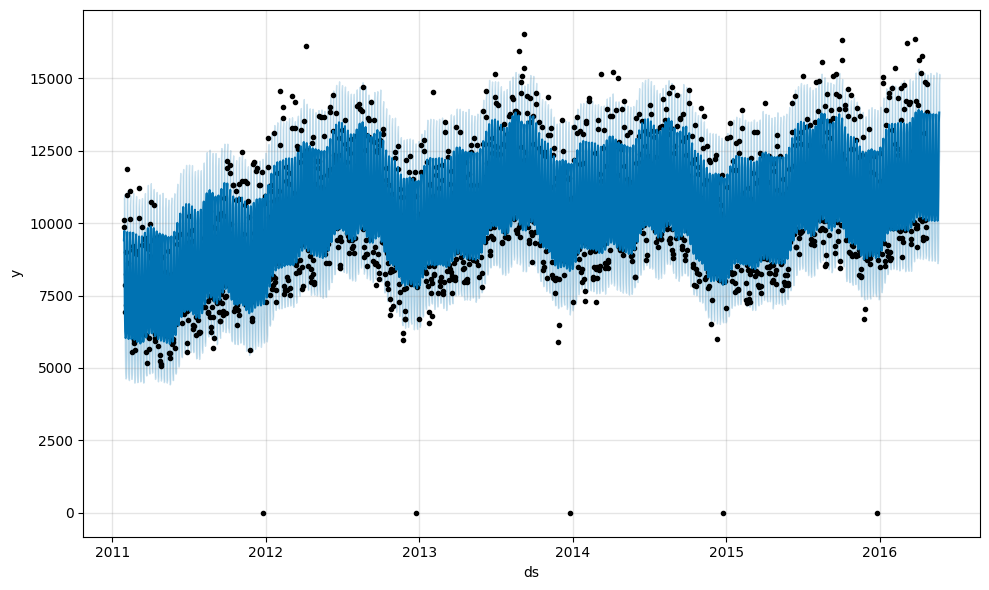

In [85]:
# Встроенный метод для отображения прогноза
# Отражается с 80% интервалом неопределенности (зависящий от тренда и шума)
fig1 = m.plot(forecast)


<span style="color:blue">**3. Декомпозиция временного ряда на составляющие**</span>




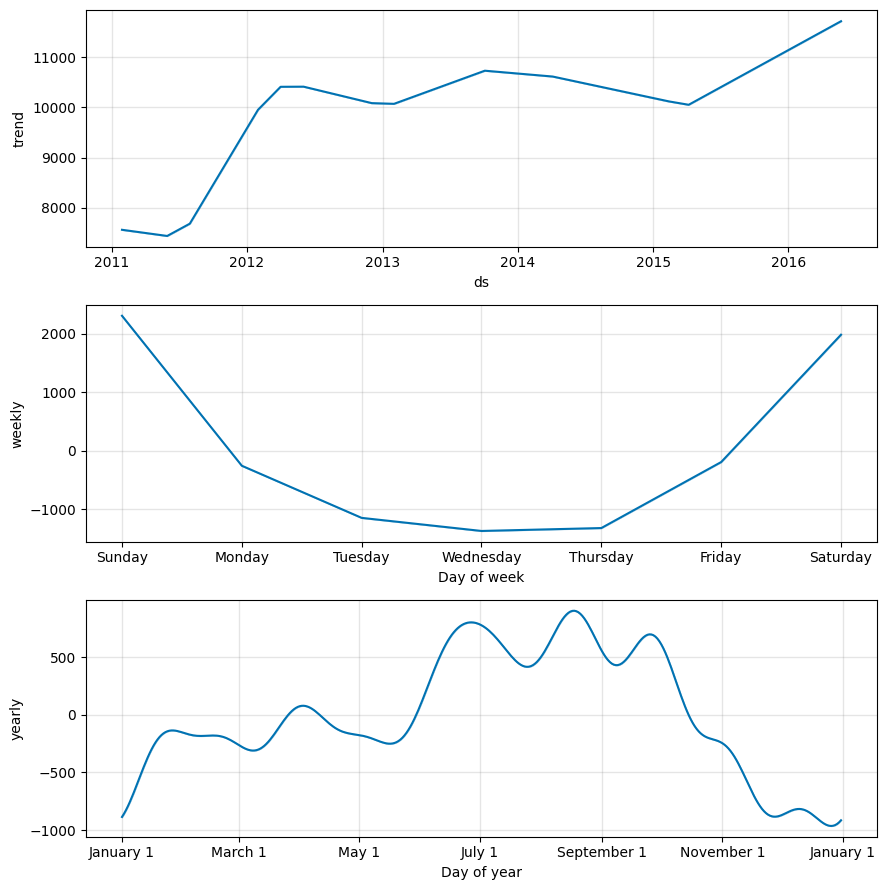

In [86]:
# Можно отразить компоненты прогноза 
# По умолчанию вы увидите тренд, годовую сезонность и недельную сезонность временного ряд
# Если вы включите праздники, вы увидите их здесь

fig2 = m.plot_components(forecast)

## Ошибка прогноза и кросс-валидация

**Метрики качества:**

Ошибки, зависящие от масштаба: 
$$\text{ Mean absolute error: }  MAE = mean(|y_t - \hat{y_t}|)$$
$$\text{ Root mean squared error: }  RMSE = \sqrt{mean(y_t - \hat{y_t})^2}$$

При этом, важно сказать, что RMSE стремится сократить **среднее** расстояние между точками, а MAE - **медианное** расстояние. 

Ошибки, не зависящие от масштаба: 

$$\text{ Mean absolute percentage error: }  MAE = mean(\frac{|y_t - \hat{y_t}|}{y_t})$$

$$\text{ Mean absolute scaled error: }  MASE = mean(\frac{y_t - \hat{y_t}}{\frac{1}{T-1}\sum^T_{t=2}|y_t-y_{t-1}|})$$ 

$$\text{ Mean absolute scaled error (for seasonal data): }  MASE = mean(\frac{y_t - \hat{y_t}}{\frac{1}{T-m}\sum^T_{t=m+1}|y_t-y_{t-m}|})$$


В практике чаще всего используются **MAPE** и его модификации:

- **MDAPE** (Median Absolute Percentage Error): $ \large median( \frac{|y_i - \hat{y_i}|}{y_i} )$ - лечит от выбросов в каком-то конкретном наблюдении
- **MTAPE** (Mean Total Percentage Error): $ \large {\frac{|\sum^h_i{y_i} - \sum^h_i{\hat{y_i}}|}{\sum^h_i{y_i}}}$ - показывает кумулятивный эффект. Используется, когда нам важно спрогнозироват именно сумму метрики за период прогноза, а не конкретное наблюдение за каждый день. 

In [87]:
# посчитаем MAPE для тестового периода

# преобразуем формат для джойна табличек
data_evaluation['ds'] = pd.to_datetime(data_evaluation['ds'])
data['ds'] = pd.to_datetime(data['ds'])
data_w_error = data_evaluation.merge(forecast[['ds','yhat']], on = ['ds'], how='left')

# считаем ошибку
data_w_error['mape'] = abs(data_w_error['y'] - data_w_error['yhat'])/data_w_error['y']


print('MAPE is: ', np.mean(data_w_error[data_w_error['ds']>max(data['ds'])]['mape']))

MAPE is:  0.06735553183369057


Про выбор оптимальной модели очень хорошо расписано здесь: [ranalytics.github](https://ranalytics.github.io/tsa-with-r/ch-intro-to-prophet.html#sec-prophet-optimal-model)

*Вкратце*:<br/> Стандартным методом оценки качества нескольких альтернативных моделей является **кросс-валидация**. 
(исходные обучающие данные случайным образом разбиваются на K частей (блоков), после чего модель k раз подгоняется по K−1 блокам, а оставшийся блок каждый раз используется для проверки качества предсказаний). 

При работе с временными рядами применяют несколько модификаций классической кросс-валидации (Hyndman and Athanasopoulos 2019; Tashman 2000). Чаще всего различают **expanding window cross-validation** и **rolling-window cross-valiadation**. В пакете fbrophet, в частности, реализован метод expanding window (Simulated Historical Forecasts, SHF).

![image.png](https://www.researchgate.net/profile/Alireza-Shojaei/publication/326380749/figure/fig1/AS:647993657159681@1531505135948/Visual-represenation-of-cross-validation-methods-used-A-Evaluation-based-on-a-fixed.png)

Функция FBProphet <code>cross_validation()</code> принимает следующие параметры:

- <code>initial</code> ("начальный отрезок") - исторические наблюдения за initial дней , образуют обучающие данные для подгонки соответствующей модели (по умолчанию составляет 3×H)


- <code>horizon</code> ("горизонт прогноза") - следующие за initial H точек наблюдений, для которых строится прогноз


- <code>period</code> - период, на который увеличивается initial перед следующим прогнозом (по умолчанию составляет H/2)


<img src= "https://i.ibb.co/nsbjc6k/2023-04-04-16-04-49.png">

Каждый раз после подгонки модели на обучающих данных из k–го блока рассчитываются предсказания для прогнозного горизонта того же блока, что позволяет оценить качество прогноза с помощью подходящей случаю метрики (например, MAPE; см. ниже). 
Значения этой метрики, усредненные по каждой дате прогнозных горизонтов каждого блока, в итоге дают оценку качества предсказаний, которую можно ожидать от модели, построенной по всем исходным обучающим данным. Это в свою очередь позволяет сравнить несколько альтернативных моделей и выбрать оптимальную.

In [88]:
df_cv = cross_validation(m, initial='730.5 days', period='28 days', horizon = '28 days', parallel="processes")

In [89]:
# результатом кросс-валидации является таблица с тренировочными данными за исключением периода initial, однко теперь
# для каждого наблюдения подсчитан прогноз
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-02-04,9118.551035,7815.497575,10472.965302,8516,2013-02-03
1,2013-02-05,8261.729633,6853.908467,9628.135670,8201,2013-02-03
2,2013-02-06,8059.007031,6681.211927,9410.693474,8256,2013-02-03
3,2013-02-07,8135.869284,6770.222591,9574.436532,8664,2013-02-03
4,2013-02-08,9333.231868,8064.525605,10643.077252,9669,2013-02-03
...,...,...,...,...,...,...
1171,2016-04-20,9992.434253,8601.305454,11472.830275,9863,2016-03-27
1172,2016-04-21,10040.591030,8667.193399,11401.762660,9479,2016-03-27
1173,2016-04-22,11162.175979,9764.105081,12561.728861,10991,2016-03-27
1174,2016-04-23,13331.375556,11955.049434,14668.726456,13845,2016-03-27


In [90]:
# функция performance_metrics подсчитывает основные виды ошибок. параметр rolling_window отвечает за долю наблюдений
# в фолде на основе которых подсчитывается ошибка. Мы используем все данные фолда для подсчета ошибки. 
res = performance_metrics(df_cv,rolling_window = 1)


In [91]:
res

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,1.525040e+06,1234.925161,907.573801,4.317474,0.06763,0.089216,0.769558


In [117]:
pb_metrics = perf_metrics_28d(m)

print(f"Performance metrics of model m:\nmdape = {round(pb_metrics.at[0,'mdape'],1)}\nMAPE = {round(pb_metrics.at[0,'mape'],1)}\n")


Performance metrics of model m:
mdape = 0.1
MAPE = 4.3



In [95]:
plotly_df(data_w_error.set_index('ds')[['y', 'yhat']], title = 'Fact vs Forecast')


## Основные параметры, влияющие на модель

[Полный список параметров модели FBProphet c описанием.](https://facebook.github.io/prophet/docs/diagnostics.html)

Все параметры отвечают за каждый из компонентов FBProphet: 
- Trend
    - **changepoint_prior_scale**
    - **changepoint_range**    
    - growth 
    - changepoints
    - n_changepoints

- Seasonality
    - **seasonality_prior_scale**
    - **seasonality_mode**  
    - yearly_seasonality 
    - weekly_seasonality

- Holidays
    - **holidays**
    - **holidays_prior_scale** 
  
В документации Профета рекомендуется настраивать именно параметры, выделенные жирным. Разберем их подробнее:

- **changepoint_prior_scale** — параметр, задающий чувствительность автоматического механизма обнаружения точек излома в тренде временного ряда y (0.05 по умолчанию). Более высокие значение позволят иметь больше таких точек излома (что одновременно увеличит риск переобучения модели)

- **changepoint_range** — доля исторических данных (начиная с самого первого наблюдения), по которым будут оценены точки излома. По умолчанию составляет 0.8 (т.е. 80% наблюдений)

- **seasonality_prior_scale** — параметр, определяющий выраженность сезонных компонент модели (10 по умолчанию). Более высокие значения приведут к более “гибкой” модели, а низкие — к модели со слабее выраженными сезонными эффектами. Этот параметр можно задать отдельно для каждого типа сезонности с помощью функции add_seasonality()

- **seasonality_mode** — режим моделирования сезонных компонент. Принимает два возможных значения: 'additive' (аддитивный, задан по умолчанию) и 'multiplicative' (мультипликативный)

- **holidays** — таблица, содержащая два обязательных столбца: holiday (текстовая переменная с названиями "праздников") и ds (даты). По желанию в такую таблицу можно добавить еще два столбца — *lower_window* и *upper_window*, которые задают отрезок времени вокруг соответствующего события. Так, например, при "lower_window = -2" в модель будут добавлены 2 дня, предшествующие соответствующему событию

- **holidays_prior_scale** — параметр, определяющий выраженность эффектов 'праздников' и других важных событий (10 по умолчанию)

<span style="color:blue">**1. Точки изменения тренда**</span>

[Почитать подробнее в доках](https://facebook.github.io/prophet/docs/trend_changepoints.html#adjusting-trend-flexibility)

In [96]:
print('Default params:\n')
# Посмотрим, какое максимально возможное количество точек изменения тренда доступно в дефолтных параметрах 
print(f'n_changepoints = {m.n_changepoints}\n')

# Посмотрим, на каком периоде исторических данных профет будет выставлять точки (на 80% по дефолту)
print(f'changepoint_range = {m.changepoint_range}\n')

# Если изменения тренда являются чрезмерными или недостаточными, вы можете отрегулировать силу влияния changepoint_prior_scale. 
# По умолчанию этот параметр установлен на 0,05. Увеличение его сделает общую тенденцию более гибкой, уменьшение менее гибкой
print(f'changepoint_prior_scale = {m.changepoint_prior_scale}\n')

Default params:

n_changepoints = 25

changepoint_range = 0.8

changepoint_prior_scale = 0.05



В автоматическом режиме при инициализации модели 25 потенциальных точек излома равномерно распределяются в пределах интервала, который охватывает первые 80% наблюдений из обучающей выборки.

Однако эти 25 точек лишь предполагаемые места существенных изменений в тренде: в большинстве случаев на практике тренд временного ряда не изменяется так часто. Поэтому в ходе подгонки модели срабатывает механизм регуляризации, в результате чего выбирается минимально необходимое количество точек излома.

Изобразить эти автоматически обнаруженные точки излома можно с помощью функции *add_changepoints_to_plot()*

Управлять степенью регулярицазии можно с помощью параметра *changepoint_prior_scale*

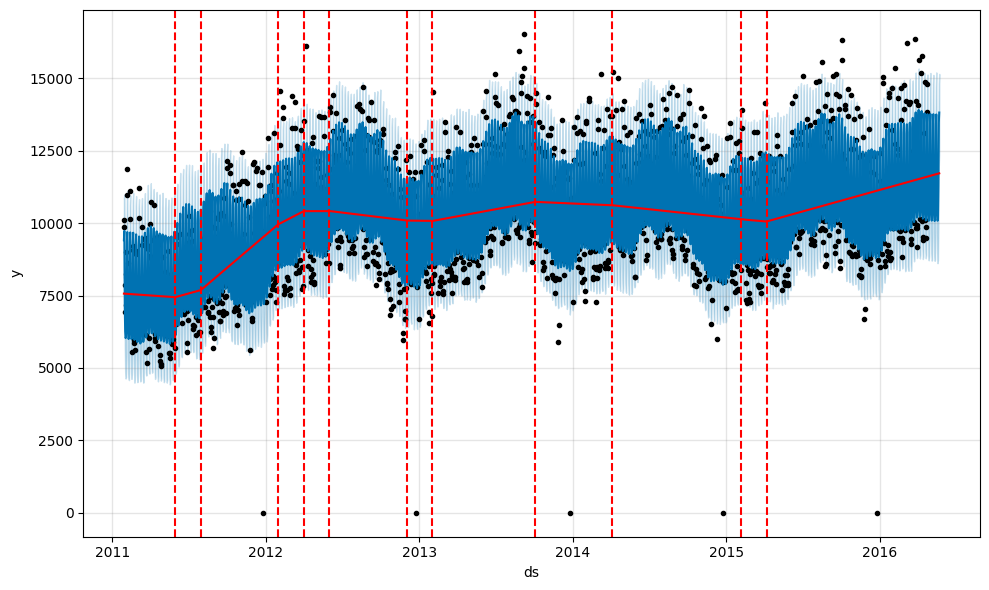

In [99]:
fig3 = m.plot(forecast)

# Добавим сетку с точками изменения тренда (профет берет не все 25, а лишь отбирает не больше 25)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

<span style="color:green">**Ответьте на вопросы:**</span>

- Что будет, если изменить **n_changepoints** (сделать показатель равным 4 или 100)?
- Что конкретно менятся в модели, если изменить **changepoint_prior_scale** (сделать показатель равным 0.005, 0.025, 0.5)? 
- Для чего нам может потребоваться сделать **changepoint_range** равным 0.95?

<span style="color:green">**Ответьте на вопрос:**</span>

- Что произошло, когда мы слишком сильно ослабили регуляризацию, какой эффект получили?

<span style="color:blue">**2. Сезонные компоненты** </span>

**Параметеры, отвечающие за компоненты сезональности**

**seasonality_prior_scale** - parameter controls the flexibility of the seasonality (usually within [0.01, 10] range)

**seasonality_mode** - parameter responsible for the magnitude of seasonality (can be ['additive', 'multiplicative'])

***yearly_seasonality*** - parameter fits yearly seasonality (сan be 'auto', True, False, or a number of Fourier terms to generate)

***weekly_seasonality*** - parameter fits weekly seasonality (сan be 'auto', True, False, or a number of Fourier terms to generate)



[Почитать здесь](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#fourier-order-for-seasonalities)

По характеру функциональной связи между своими компонентами модели временных рядов делятся на два основных типа — аддитивные и мультипликативные.<br/>Первый из них применяется в случаях, когда амплитуда сезонных колебаний приблизительно постоянна. Если же эта амплитуда заметно изменяется во времени (обычно возрастает), то строят мультипликативную модель.


![image.png](https://www.researchgate.net/publication/348592737/figure/fig2/AS:981645804961802@1611054006728/Examples-for-multiplicative-and-additive-relationship-between-time-series-components.png)

[Про мультипликативную сезональность](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html)

<span style="color:green">**Ответьте на вопрос:**</span>

- **Какие примеры временных рядов будут иметь скорее аддитивную сезональность? А мультипликативную?**


In [100]:
plotly_df(data.set_index('ds')[['y']], title = 'Fact vs Forecast')


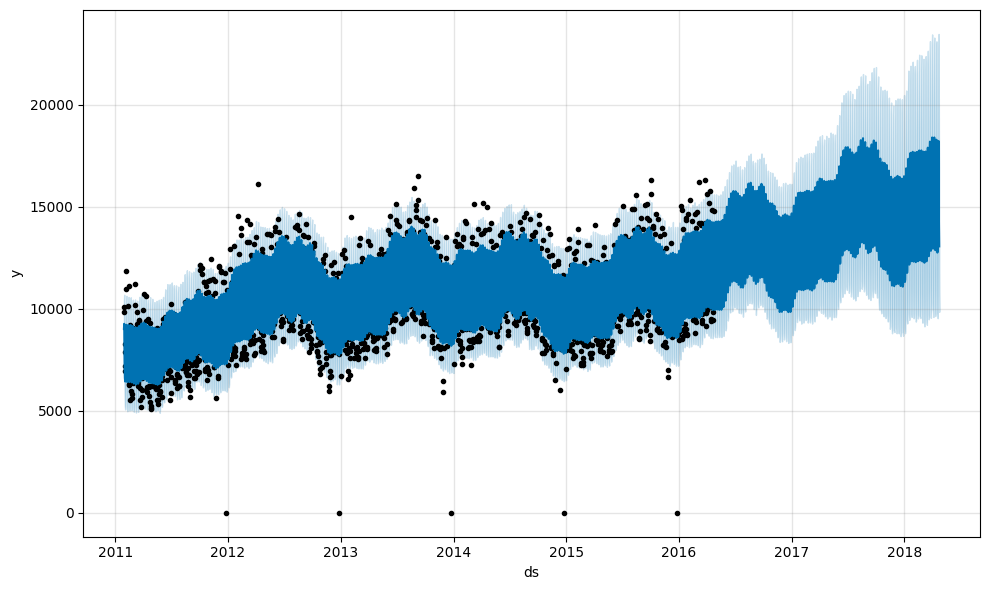

In [119]:
# Посмотрим, что будет при additive

m_4 = fp.Prophet(
    seasonality_mode = 'multiplicative')

m_4.fit(data)

future = m_4.make_future_dataframe(periods=365*2)

forecast = m_4.predict(future)
fig6 = m.plot(forecast)

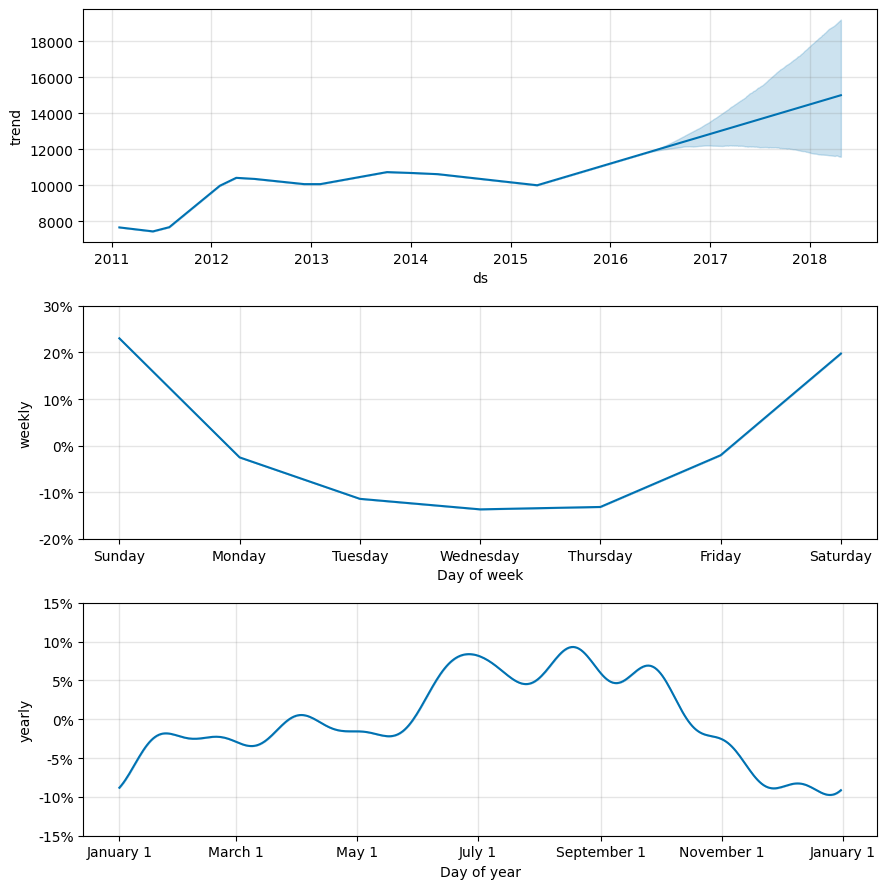

In [120]:
fig6_5 = m_4.plot_components(forecast)

<span style="color:purple">**Посчитаем медианную ошибку в процентах на прошлом на горизонте 28 дней**</span>

In [124]:
%%time

m4_metrics = perf_metrics_28d(m_4)
m4_metrics

CPU times: user 309 ms, sys: 496 ms, total: 804 ms
Wall time: 6.26 s


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,1.427560e+06,1194.805324,870.391493,4.233364,0.064735,0.085526,0.784864


In [125]:
# Сравним полученные значения метрик с базовой моделью
pb_metrics


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,1.525040e+06,1234.925161,907.573801,4.317474,0.06763,0.089216,0.780612


Одним из более тонких параметров - порядок Фурье. Порядок Фурье определяет, насколько быстро может измениться сезональность (по умолчанию для годовой сезональности — 10, для недельной сезональности — 3). Увеличение порядка Фурье позволяет сезональности подстраиваться к быстро меняющимся циклам.

![image.png](https://miro.medium.com/max/512/1*hBR26OFeHQgRS2XFC3QZMA.gif)

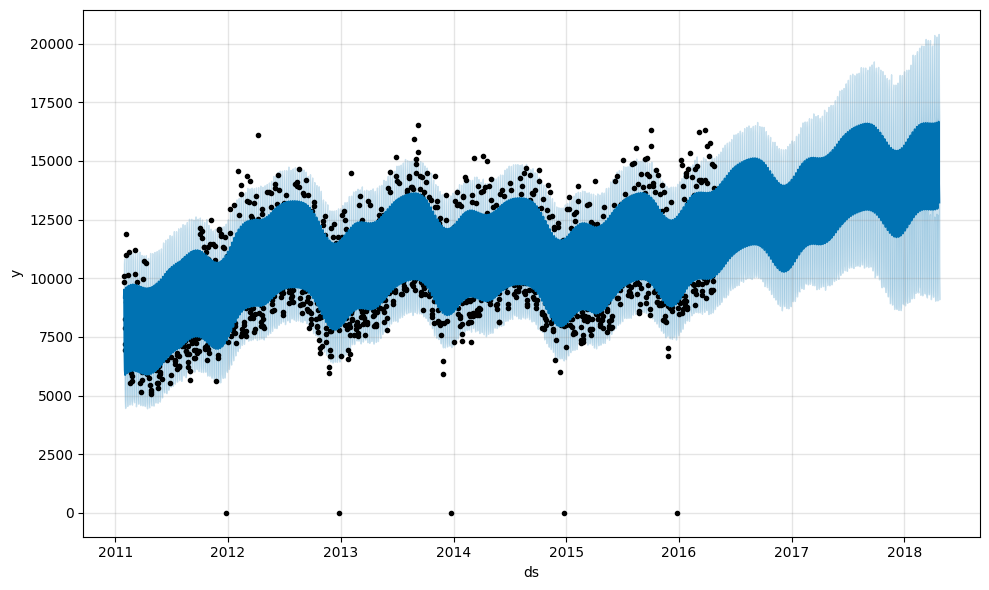

In [126]:
# Посмотрим, что будет при более тонкой настройке 

m_5 = fp.Prophet(
    seasonality_mode = 'additive',
    yearly_seasonality = False)

m_5.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'additive')
m_5.fit(data)

future = m_5.make_future_dataframe(periods=365*2)

forecast = m_5.predict(future)
fig7 = m.plot(forecast)



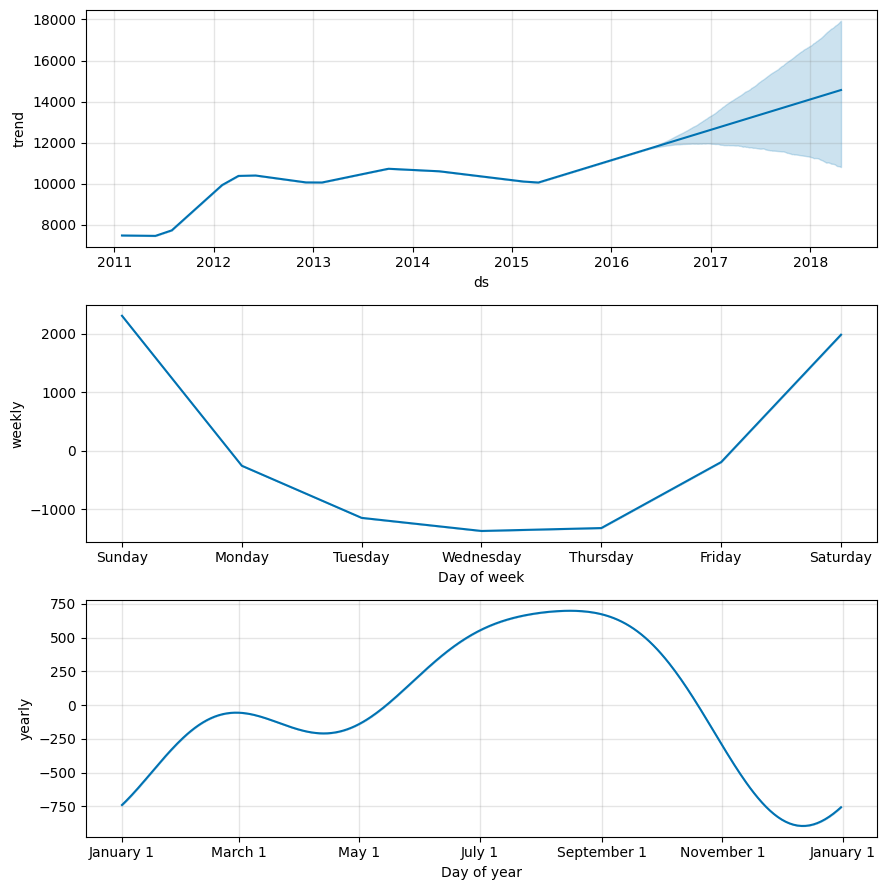

In [127]:
fig7_5 = m_5.plot_components(forecast)

In [128]:
%%time

m5_metrics = perf_metrics_28d(m_5)
m5_metrics

CPU times: user 388 ms, sys: 613 ms, total: 1 s
Wall time: 6.14 s


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,1.448379e+06,1203.486014,871.712123,4.258748,0.064276,0.08577,0.792517


In [129]:
# Сравним полученные значения метрик с базовой моделью
pb_metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,1.525040e+06,1234.925161,907.573801,4.317474,0.06763,0.089216,0.780612


<span style="color:green">**Ответьте на вопрос:**</span>

- **Что будет, если задать недельную сезонную компоненту аддитивной, а годовую мультипликативной?**
- **А наоборот?**
- **Что будет, если увеличить порядок Фурье для недельной сезональности?**

<span style="color:blue">**3. Эффекты праздников** </span>

Performance metrics of model m_5:
mdape = 6.1%
coverage = 81.6%



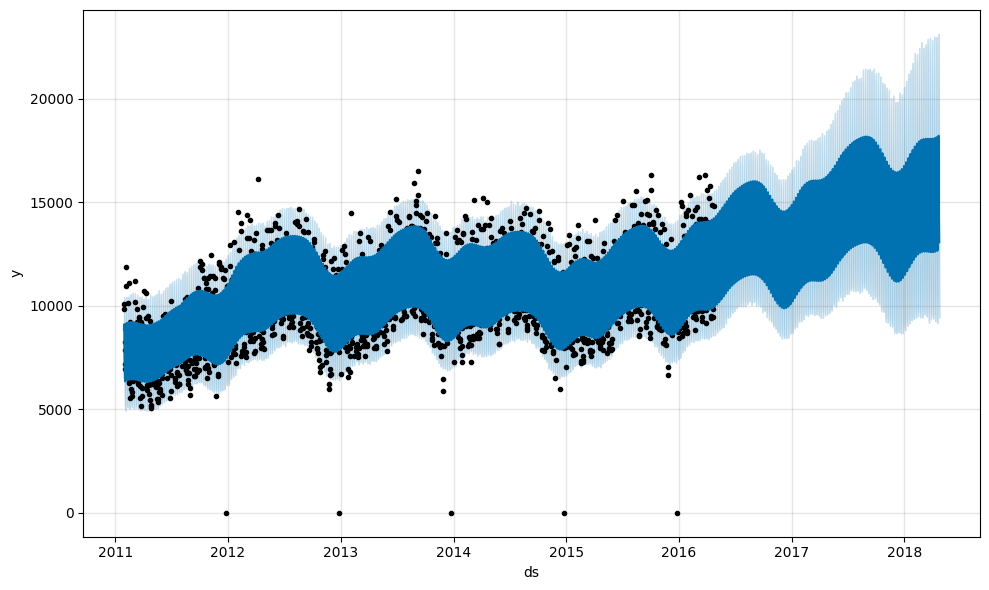

In [130]:
# Посмотрим еще раз на получившийся прогноз (с тонкой настройкой сезонных компонент)

m_5 = fp.Prophet(
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_5.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'multiplicative')
m_5.fit(data)

future = m_5.make_future_dataframe(periods=365*2)

forecast = m_5.predict(future)
fig7 = m.plot(forecast)


pm_metrics = perf_metrics_28d(m_5)
print(f"Performance metrics of model m_5:\nmdape = {round(pm_metrics.at[0,'mdape']*100,1)}%\ncoverage = {round(pm_metrics.at[0,'coverage']*100,1)}%\n")


Для наших целей воспользуемся библиотекой holdays  - c ее помощью создадим датафрейм с праздниками под формат fbprophet

In [131]:
import holidays

us_ca_holidays = holidays.UnitedStates(state='CA', years = [2011,2012,2013,2014,2015,2016,2017,2018], \
                                       observed = False)

holiday_df = pd.DataFrame.from_dict(us_ca_holidays, orient='index').reset_index(drop = False)
holiday_df.columns = ['ds', 'holiday']
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df['lower_window'] = -1
holiday_df['upper_window'] = 1
holiday_df = holiday_df[['holiday', 'ds', 'lower_window', 'upper_window']]

# В данных calendar в качестве событий были отмечены Пасха и День отца
# Эти два регулярных события тоже могут отражаться на покупках (следует проверить данный факт отдельно)
# Но сейчас в рамках нашей задачи мы так же вынесем эти дни + Valentine's Day в датафрейм с праздниками
# В эти дни продажи отличаются от аналогичных обычных дней

custom_holidays = pd.DataFrame([{'holiday' : "Father's day", 'ds' : datetime.date(2011,6,19), \
                                 'lower_window':-2, 'upper_window':0},
 {'holiday' : "Father's day", 'ds' : datetime.date(2012,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2013,6,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2014,6,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2015,6,21), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2016,6,19), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2017,6,18), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2018,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2011,4,24), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2012,4,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2013,5,5), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2014,4,20), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2015,4,12), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2016,5,1), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2017,4,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2018,4,8), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2011,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2012,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2013,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2014,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2015,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2016,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2017,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2018,2,14), 'lower_window':-1, 'upper_window':1}])

holiday_df = pd.concat([holiday_df, custom_holidays])
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df.head()

,holiday,ds,lower_window,upper_window
0,New Year's Day,2011-01-01,-1,1
1,Martin Luther King Jr. Day,2011-01-17,-1,1
2,Valentine's Day,2011-02-14,-1,1
3,Washington's Birthday,2011-02-21,-1,1
4,César Chávez Day,2011-03-31,-1,1


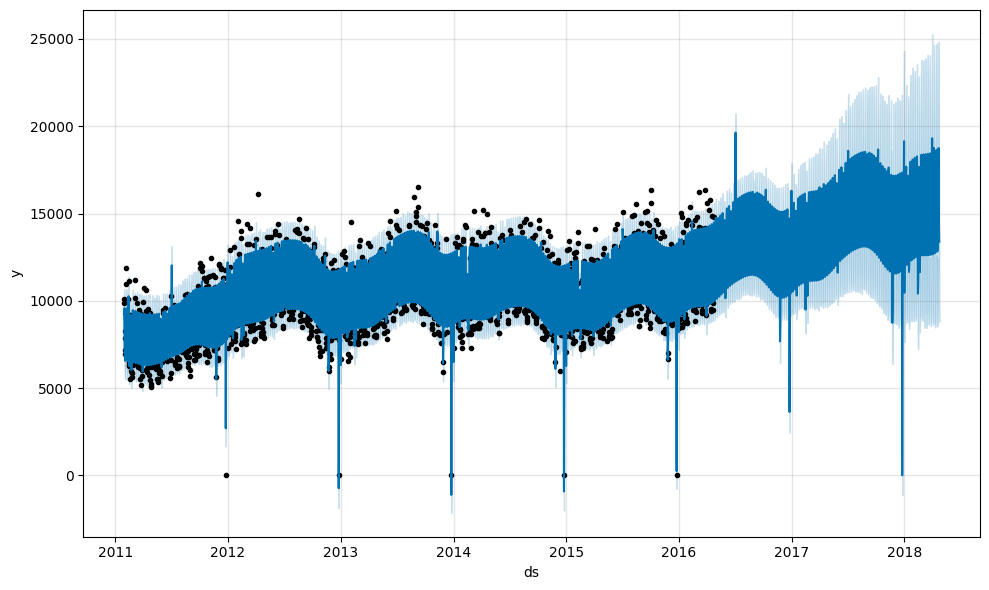

In [132]:
# Посмотрим, что будет при учете праздников

m_6 = fp.Prophet(
    holidays = holiday_df,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_6.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'multiplicative')

m_6.fit(data)

future = m_6.make_future_dataframe(periods=365*2)

forecast = m_6.predict(future)
fig8 = m_6.plot(forecast)

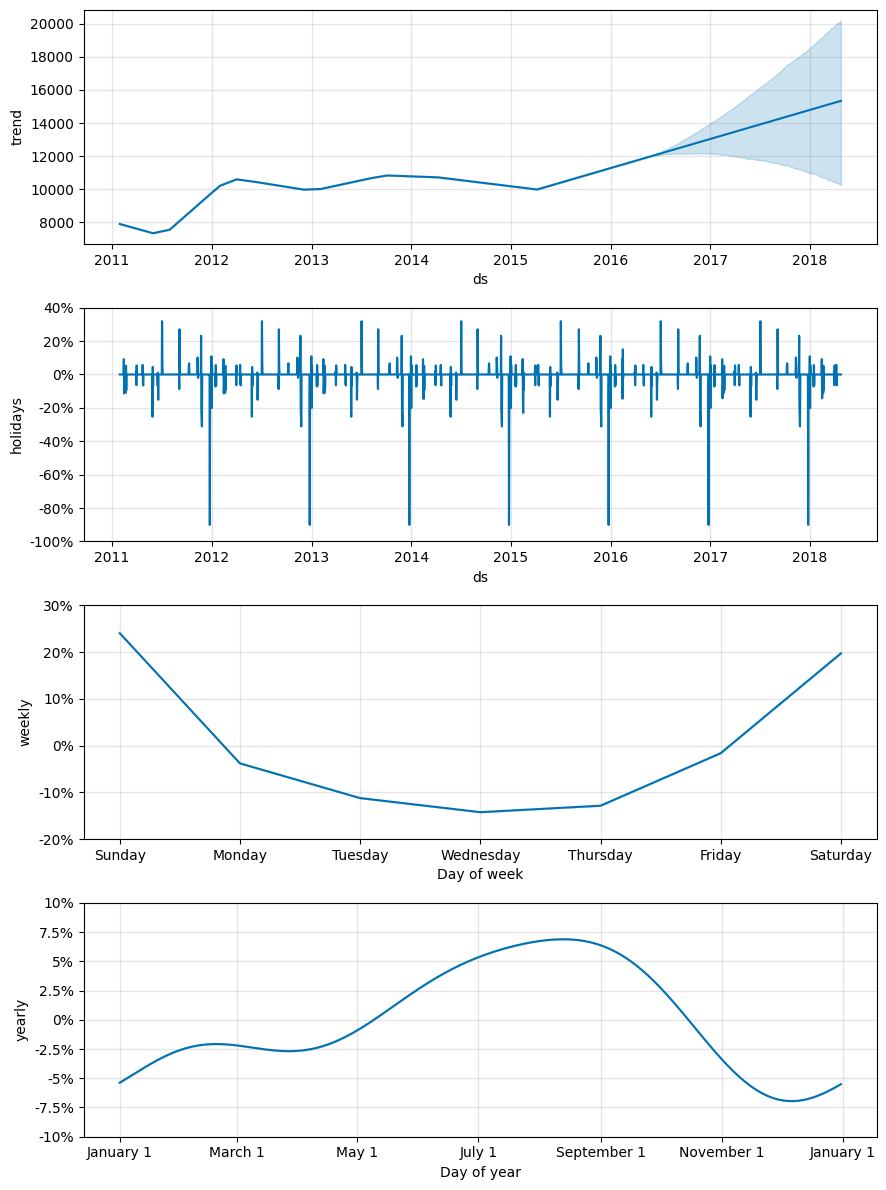

In [133]:
fig8_5 = m_6.plot_components(forecast)

<span style="color:purple">**Посчитаем медианную процентную ошибку на прошлом на горизонте 28 дней**</span>

In [134]:
%%time

m6_metrics = perf_metrics_28d(m_6)
m6_metrics

CPU times: user 285 ms, sys: 530 ms, total: 815 ms
Wall time: 6.63 s


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,948876.910194,974.103131,750.834391,0.659158,0.057594,0.075639,0.75


In [135]:
# Сравним с показателями модели с sesonal_mode = 'multiplicative'
pm_metrics


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,1.341736e+06,1158.333312,829.935158,4.158006,0.060918,0.081639,0.816327


Также важным параметром, влияющим на прогноз является <code>holidays_prior_scale</code>.  Обычно параметр изменяется в пределах [0.01, 10], при этом, чем выше этот параметр, тем меньше регуляризация, а значит сильнее выражены эффекты "праздника". Дефолтное значение параметра - 10 (отсутствие регуляризации).

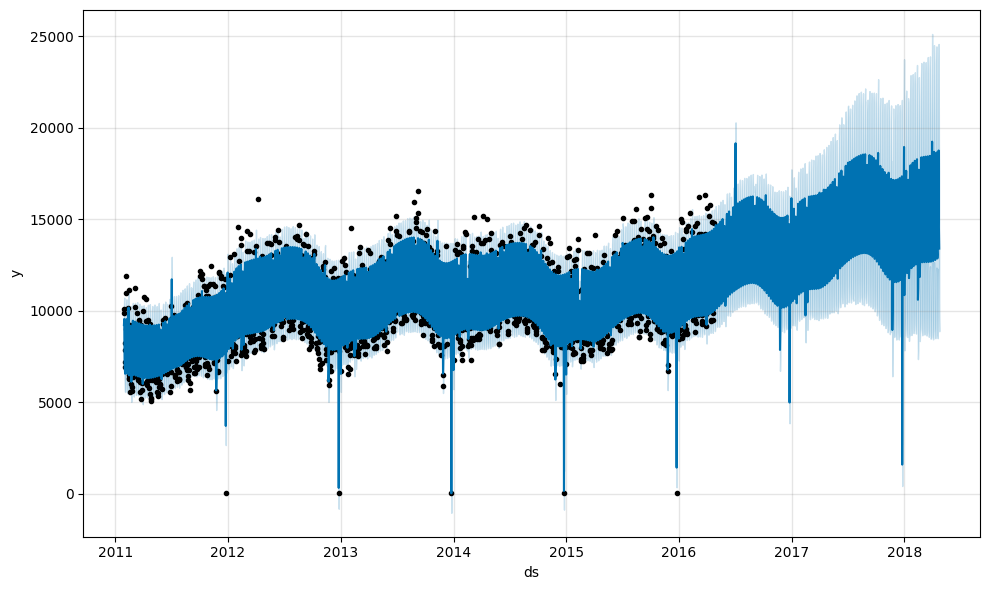

In [136]:
# Посмотрим, что будет при учете праздников

m_6 = fp.Prophet(
    holidays = holiday_df,
    holidays_prior_scale=0.1,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_6.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'multiplicative')

m_6.fit(data)

future = m_6.make_future_dataframe(periods=365*2)

forecast = m_6.predict(future)
fig8 = m_6.plot(forecast)

In [ ]:
%%time

p_metrics = perf_metrics_28d(m_6)
print(f"Performance metrics of model m_6:\nmdape = {round(p_metrics.at[0,'mdape']*100,1)}%\ncoverage = {round(p_metrics.at[0,'coverage']*100,1)}%\n")

<span style="color:green">**Ответьте на вопрос:**</span>

- **Влияют ли как-то на продажи домашних товаров спортивные мероприятия?** 

Для этого используйте файл calendar.csv и выберите <code>event_type_1=='Sporting'</code>


In [ ]:
# Cправочник дат
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2']]

### Добавление нового предиктора

Дополнительные регрессоры могут быть добавлены к линейной части модели с использованием add_regressor метода. 

Столбец со значением регрессора должен присутствовать как во фреймах данных, так и в прогнозе. 

На графике компонентов этот эффект будет отображаться на графике extra_regressors

**Попробуем добавить дополнительный регрессор 30 мая 2015 (там можно наблюдать "ступеньку" в данных)**



In [ ]:
# Посмотрим еще раз на первоначальные данные
plotly_df(data.set_index('ds'), title = 'CA items sold in household category')

In [ ]:
# Просто проставляем 1, если данные после начала запуска производства в РФ и 0 в иных случаях

def period_after(ds):
    if ds >= datetime.date(2015,5,30):
        return 1
    else:
        return 0

In [ ]:
# Добавляем и в обучающие данные и в future значение дополнительного регрессора 

df['after_something'] = df['ds'].apply(period_after)

In [ ]:
df

In [ ]:
m_8 = fp.Prophet(
    holidays = holiday_df,
    holidays_prior_scale=0.1,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_8.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'multiplicative')

# Добавляем регрессор до fit
m_8.add_regressor('after_something', mode='additive')

m_8.fit(df)

future = m_8.make_future_dataframe(periods=365*2)
future['after_something'] = future['ds'].apply(period_after)

forecast = m_8.predict(future)

fig9 = m_8.plot(forecast)
a = add_changepoints_to_plot(fig9.gca(), m_8, forecast)


In [ ]:
fig10 = m_8.plot_components(forecast)

<span style="color:purple">**Посчитаем медианную ошибку в процентах на прошлом на горизонте 28 дней**</span>

In [ ]:
%%time

p_metrics = perf_metrics_28d(m_8)
print(f"Performance metrics of model m_8:\nmdape = {round(p_metrics.at[0,'mdape']*100,1)}%\ncoverage = {round(p_metrics.at[0,'coverage']*100,1)}%\n")

In [ ]:
# Сравним с ошибкой предыдущей модели

pm_metrics = perf_metrics_28d(m_6)
print(f"Performance metrics of model m_6:\nmdape = {round(pm_metrics.at[0,'mdape']*100,1)}%\ncoverage = {round(pm_metrics.at[0,'coverage']*100,1)}%\n")

<span style="color:green">**Ответьте на вопрос:**</span>

- **Влияют ли как-то на продажи участие магазина в SNAP программе?** SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program)

Для этого используйте файл calendar.csv и выберите колонку snap_CA. 



In [ ]:
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'snap_CA']]
calendar

## <span style="color:green">**Заключительное задание:**</span>

В качестве заключительного задания я предлагаю построить прогноз для категории Foods в Техасе. Здесь нужно обратить внимание на "ступеньки", которые случились в Июне и Августе 2012 года. 

In [ ]:
# Выделим только данные по Техасу
ca_data = sales_train_validation.loc[sales_train_validation.state_id == 'TX', ['ds', 'cat_id', 'y']].copy()

# Посмотрим на распрделение продаж по категориям
plotly_df(ca_data.pivot(index='ds', columns='cat_id', values='y'), title = 'TX items sold')